In [4]:
# %%capture
import torch
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

from NashRL import *
# from nashRL_netlib import *
from NashAgent_lib import *
from textwrap import wrap
from visualization import *

import seaborn as sns
            
#Initialize a dummy agent
num_players = 5           # Total number of agents
T = 8                    # Total number of time steps

#Default simulation parameters
sim_dict = {'perm_price_impact': .3,
            'transaction_cost': .5,
            'liquidation_cost': .5,
            'running_penalty': 0,
            'T': T*10,
            'dt': 1/10,
            'N_agents': num_players,
            'drift_function': (lambda x, y: 3*0.1*(10-y)),
            'volatility': 1,
            'initial_price_var': 3}


sim_obj = MarketSimulator(sim_dict,store_hist = True)
net_non_inv_dim = len(sim_obj.get_state()[0].to_numpy())
net_non_inv_dim -= sim_obj.N-1
out_dim = 4

nash_agent = NashNN(non_invar_dim=net_non_inv_dim,n_players=sim_obj.N,
                    output_dim=4, max_steps=T, 
                    terminal_cost=0.5, num_moms=5)

#Load saved network parameters from file
# net_file_name = "Action_Net"
net_file_name = "./pt_files/Action_Net_ADA_15022021.pt"

nash_agent.action_net.load_state_dict(torch.load(net_file_name))


<All keys matched successfully>

In [5]:
def plot_sample_paths(agent_obj,num_sims,sim_obj,random_seed = None):
    nrows0 = int(np.ceil(num_sims/3))
    fig, axes = plt.subplots(nrows=nrows0, ncols=3,dpi=160)
    matplotlib.rc('font', **font)
    sim_obj.store_hist = True # Ensure object stores its own history
    for i in range(nrows0):
        if not random_seed == None: np.random.seed(random_seed)
        for j in range(0,3):
            sim_obj.reset()
            for _ in range(0, T):
                current_state,lr,tr = sim_obj.get_state()
                a = agent_obj.predict_action([current_state])[0].mu.cpu().data.numpy()
                sim_obj.step(a)

            inv_list = np.array([ x.q for x in sim_obj.state_hist])
            px_list = np.array([ x.p for x in sim_obj.state_hist])
            imp_list = np.array([ x.i for x in sim_obj.state_hist])
            
            # Generate Simulation Plots
            plt.subplot(int(np.ceil(num_sims/3)), 3, int(i*3+j)+1)

            ax = plt.gca()
            ax.grid(False)
            ax2 = ax.twinx()
            ax2.grid(False)
            ax.plot(inv_list,linewidth=1)
            ax.set_ylim((-20, 20))
            ax2.set_ylim((3, 20))
            ax2.plot(px_list, 'k--',linewidth=1.5)
            ax2.plot(imp_list, ':', color='black', linewidth=1.5)
            ax.tick_params(axis='both', which='major', labelsize=5)
            ax2.tick_params(axis='both', which='major', labelsize=5)
            ax2.yaxis.set_major_locator(MaxNLocator(integer=True, nbins = 10))
            
            #remove inner ticks
            if j < 2:
                ax2.yaxis.set_visible(False)
            if j > 0:
                ax.yaxis.set_visible(False)
            if i < 2:
                ax.xaxis.set_visible(False)
                
    fig.text(0.5, 0.03, 'Time', ha='center', fontdict = {'size': 5})
    fig.text(0.05, 0.5, 'Inventory', va='center', rotation='vertical',fontdict = {'size': 5})
    fig.text(.95, 0.5, 'Price', va='center', rotation='vertical',fontdict = {'size': 5})
    plt.savefig('SamplePaths')


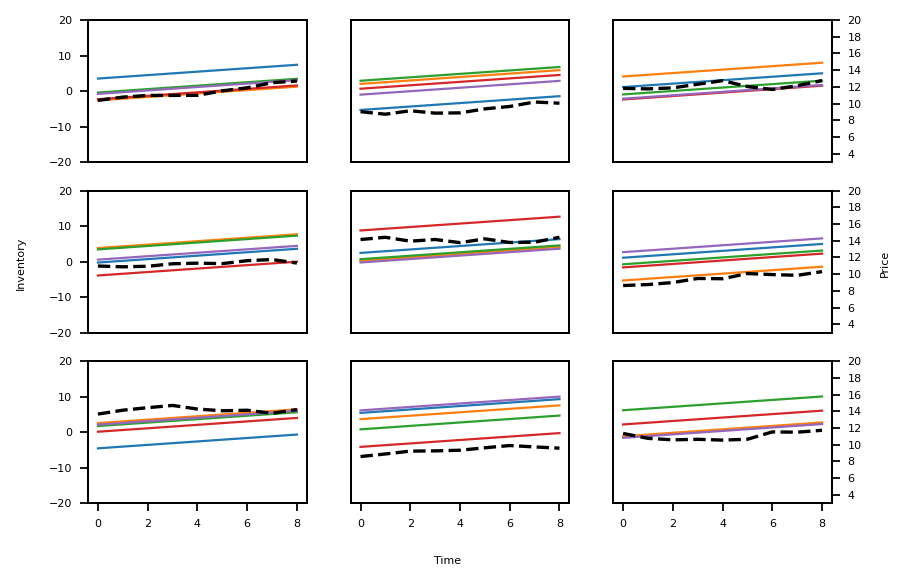

In [6]:
plot_sample_paths(nash_agent,num_sims=9,sim_obj=sim_obj)

In [9]:
net_tmp = nash_agent


sim_dict = {'perm_price_impact': .3,
            'transaction_cost': .5,
            'liquidation_cost': .5,
            'running_penalty': 0,
            'trans_impact_scale':0.15,
            'trans_impact_decay':0.25*np.log(2),
            'T': 8,
            'dt': 10./60.,
            'N_agents': num_players,
            'drift_function': (lambda x, y: 2*(10-y)),
            'volatility': 1,
            'initial_price_var': 1}

sim_obj = MarketSimulator(sim_dict,store_hist = True)


meta_px_list = []
meta_imp_list = []
meta_inv_list = []
meta_rew_list = []
for _ in range(30):
    sim_obj.reset()
    while not sim_obj.done:
        current_state,lr,tr = sim_obj.get_state()
        a = nash_agent.predict_action([current_state])[0].mu.cpu().data.numpy()
        sim_obj.step(a)
        # sim_obj.step(np.zeros_like(a)-10)
    # inv_list = np.array([ x.q for x in sim_obj.state_hist])
    px_list = np.array([ x.p for x in sim_obj.state_hist])
    imp_list = np.array([ x.i for x in sim_obj.state_hist])
    inv_list = np.array([ np.mean(x.q) for x in sim_obj.state_hist])
    rew_list = np.array([ np.mean(x) for x in sim_obj.reward_hist])

    meta_px_list.append(px_list)
    meta_imp_list.append(imp_list)
    meta_inv_list.append(inv_list)
    meta_rew_list.append(rew_list)


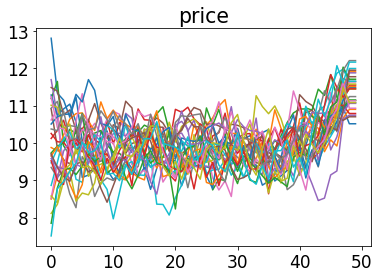

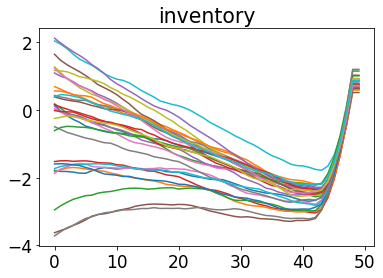

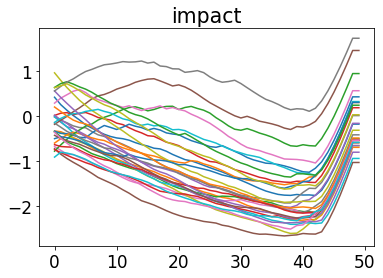

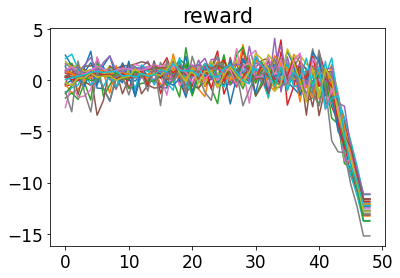

In [10]:
# %matplotlib notebook
plt.clf()
plt.plot(np.array(meta_px_list).T)
plt.title('price')
plt.show()

plt.clf()
plt.plot(np.array(meta_inv_list).T)
plt.title('inventory')
plt.show()

plt.clf()
plt.plot(np.array(meta_imp_list).T)
plt.title('impact')
plt.show()


plt.clf()
plt.plot(np.array(meta_rew_list).T)
plt.title('reward')
plt.show()

# meta_px_list = np.array(meta_px_list)
# hist_heat = np.array([np.histogram(meta_px_list[:,i],bins=100,range=(4,17),density=True)[0] for i in range(meta_px_list.shape[1])])

# plt.imshow(hist_heat.T)
# # sns.heatmap(hist_heat.T, linewidth=0.3)
# plt.show()

